<a href="https://colab.research.google.com/github/utkarshkant/NYC-Taxi-Demand_Time-Series/blob/main/NYC_Taxi_Demand_Time_Series_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection in Time Series Data
Anomaly detection involves identifying data-points that deviate from normal behavior (or outliers).

The anomalous data can indicate critical incidents in business or even a potential opportunity that you can take advantage of.

## Use case
- Fraud Detection
- Product Quality Issues in Manufacturing Line
- Application Performance Management (CPU Spikes or Memory Spikes)

## Types of Anomaly Detection
1. Global Outlier: Exists far outside the entirety of the dataset.
2. Contexual Outlier: Values occur within the data value expectation but are outlier in certain perspective like seasonality


In [1]:
!pip install fbprophet

In [35]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px
from fbprophet import Prophet

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [17]:
# load data
df = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv")

In [18]:
# preview data
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


- data is half-hourly

In [19]:
# metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [20]:
# size of dataset
df.shape

(10320, 2)

In [22]:
# convert 'timestamp' feature into datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
# club half-hourly data into hourly data
df = df.set_index('timestamp').resample("H").mean()

In [25]:
# preview data
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


In [24]:
# size of dataset
df.shape

(5160, 1)

In [34]:
# plot data
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
# plot configurations
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                          dict(count=1, label="1y", step="year", stepmode="backward"),
                          dict(count=2, label="3y", step="year", stepmode="backward"),
                          dict(count=3, label="5y", step="year", stepmode="backward"),
                          dict(step="all")
                     ])
                 ))
# display plot
fig.show()

- some spikes at Nov 2, 2014 and Dec 31, 2014
- some lows at Jul 4, 2014 and Dec 25, 2014

In [36]:
# let us create a model to confirm outliers

# format data for fbprophet
taxi_df = df.reset_index()[['timestamp','value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')
# preview data
taxi_df

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [41]:
(119/5160)*100

2.306201550387597

In [37]:
# train test split
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds']) > '2015-01-27']    # 4 days of hourly data

In [38]:
print(train.shape)
print(test.shape)

(5041, 2)
(119, 2)


In [42]:
test

,ds,y
5041,2015-01-27 01:00:00,39.5
5042,2015-01-27 02:00:00,29.0
5043,2015-01-27 03:00:00,9.5
5044,2015-01-27 04:00:00,14.5
5045,2015-01-27 05:00:00,29.0
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [50]:
# create prophet model
m = Prophet(changepoint_range=0.95)   # confidence interval
# train model
m.fit(train)
# create future dataframe
future = m.make_future_dataframe(periods=119, freq='H')
print(future.tail(167))  # it has only dates and no outputs

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


                      ds
4993 2015-01-25 01:00:00
4994 2015-01-25 02:00:00
4995 2015-01-25 03:00:00
4996 2015-01-25 04:00:00
4997 2015-01-25 05:00:00
...                  ...
5155 2015-01-31 19:00:00
5156 2015-01-31 20:00:00
5157 2015-01-31 21:00:00
5158 2015-01-31 22:00:00
5159 2015-01-31 23:00:00

[167 rows x 1 columns]


In [49]:
# forecast
forecast = m.predict(future) 
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19012.248223,28396.711292
5156,2015-01-31 20:00:00,24342.584334,19590.943984,29421.889785
5157,2015-01-31 21:00:00,23219.297735,18208.357189,27639.153095
5158,2015-01-31 22:00:00,21027.355314,16419.691060,25932.603001
5159,2015-01-31 23:00:00,18500.216845,13961.955068,22953.608265


In [51]:
# final results
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
# preview results
results

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8259.744832,18160.727288
2014-07-01 01:00:00,5433.0,10232.486172,5539.976896,15076.048244
2014-07-01 02:00:00,3346.5,6669.099458,2153.896353,11626.651206
2014-07-01 03:00:00,2216.5,3448.054270,-1507.770820,8199.832985
2014-07-01 04:00:00,2189.5,2017.409931,-2990.645481,6658.719778
...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19012.248223,28396.711292
2015-01-31 20:00:00,24138.0,24342.584334,19590.943984,29421.889785
2015-01-31 21:00:00,24194.5,23219.297735,18208.357189,27639.153095


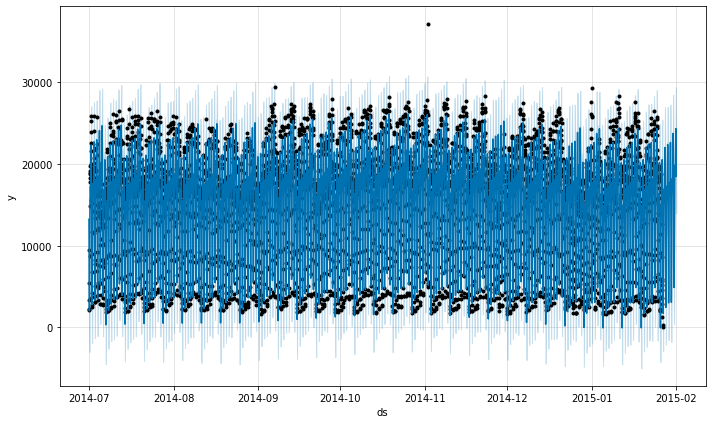

In [55]:
# plot forecast
fig1 = m.plot(forecast)

- outliers can be observed


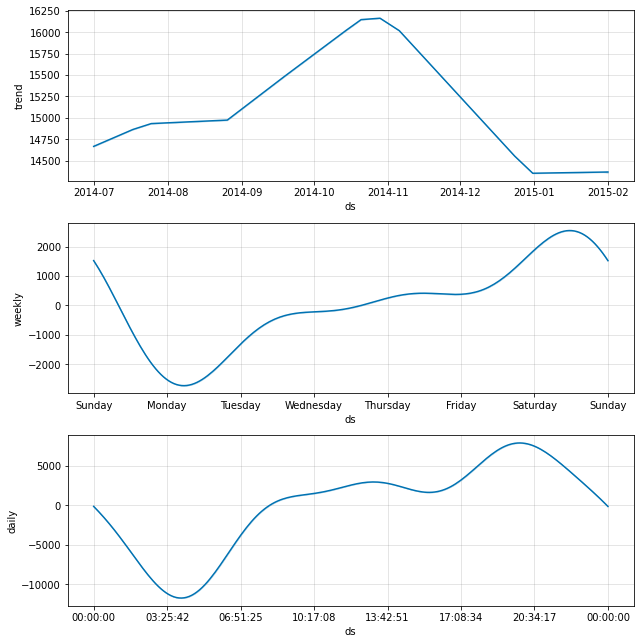

In [53]:
# plot forecast components
comp = m.plot_components(forecast)

Trend
- increasing trend till October 2014
- then decreasing till January 2015 and then plateau

Weekly
- sharp drop on sundays
- demand increases Monday onwards till weekend

Hourly
- decreases from midnight to about 4am
- increasing pattern from 4am till 8pm in night
- slow decrease from 8pm to midnight

In [57]:
# residual calculation
results['error'] = results['y'] - results['yhat']
# uncertainty
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']
# preview results
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8259.744832,18160.727288,-3755.232792,9900.982456
2014-07-01 01:00:00,5433.0,10232.486172,5539.976896,15076.048244,-4799.486172,9536.071347
2014-07-01 02:00:00,3346.5,6669.099458,2153.896353,11626.651206,-3322.599458,9472.754853
2014-07-01 03:00:00,2216.5,3448.054270,-1507.770820,8199.832985,-1231.554270,9707.603805
2014-07-01 04:00:00,2189.5,2017.409931,-2990.645481,6658.719778,172.090069,9649.365260
...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19012.248223,28396.711292,4509.970787,9384.463069
2015-01-31 20:00:00,24138.0,24342.584334,19590.943984,29421.889785,-204.584334,9830.945801
2015-01-31 21:00:00,24194.5,23219.297735,18208.357189,27639.153095,975.202265,9430.795906


In [58]:
# outlier detection
results[results['error'].abs() > 1.5*results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9659.116428,19157.378055,22985.607130,9498.261626
2015-01-01 01:00:00,29292.0,11405.545567,6767.219642,16300.418711,17886.454433,9533.199069
2015-01-01 02:00:00,25753.5,7770.054639,3464.844709,12565.073715,17983.445361,9100.229005
2015-01-01 03:00:00,22067.0,4478.895177,-270.083427,9293.524511,17588.104823,9563.607938
2015-01-26 19:00:00,4565.5,19771.308307,15098.047421,24436.829850,-15205.808307,9338.782429
2015-01-26 20:00:00,3630.5,20546.581743,15940.615803,25475.625567,-16916.081743,9535.009764
2015-01-26 21:00:00,2907.0,19647.710004,14851.269163,24854.023802,-16740.710004,10002.754638
2015-01-26 22:00:00,1324.5,17691.969234,13058.236817,22334.212038,-16367.469234,9275.975222
2015-01-26 23:00:00,243.0,15411.348672,10906.019943,20235.090629,-15168.348672,9329.070687


Let's observe the outliers
- First record has a spike on 2nd Nov, 2014
  - It could be due to a marathon event in New York where demand must have increased sharply

- 3 outliers from 1st Jan
  - Due to new year's eve, the demand is different from normal demand

These are examples of contexual outliers
- 26 Jan, 2016
  - Snow storm in NYC which result in sharp decrease in taxi demand

In [61]:
# create feature for anomaly
results['anomaly'] = results.apply(lambda x: "Yes" if(np.abs(x['error']) > 1.5*x['uncertainty']) else "No", axis=1)

In [62]:
# preview results
results

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8259.744832,18160.727288,-3755.232792,9900.982456,No
2014-07-01 01:00:00,5433.0,10232.486172,5539.976896,15076.048244,-4799.486172,9536.071347,No
2014-07-01 02:00:00,3346.5,6669.099458,2153.896353,11626.651206,-3322.599458,9472.754853,No
2014-07-01 03:00:00,2216.5,3448.054270,-1507.770820,8199.832985,-1231.554270,9707.603805,No
2014-07-01 04:00:00,2189.5,2017.409931,-2990.645481,6658.719778,172.090069,9649.365260,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,19012.248223,28396.711292,4509.970787,9384.463069,No
2015-01-31 20:00:00,24138.0,24342.584334,19590.943984,29421.889785,-204.584334,9830.945801,No
2015-01-31 21:00:00,24194.5,23219.297735,18208.357189,27639.153095,975.202265,9430.795906,No


In [68]:
# plot data
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')
# plot configurations
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(
                     buttons=list([
                          dict(count=1, label="1y", step="year", stepmode="backward"),
                          dict(count=2, label="3y", step="year", stepmode="backward"),
                          dict(count=3, label="5y", step="year", stepmode="backward"),
                          dict(step="all")
                     ])
                 ))
# display plot
fig.show()

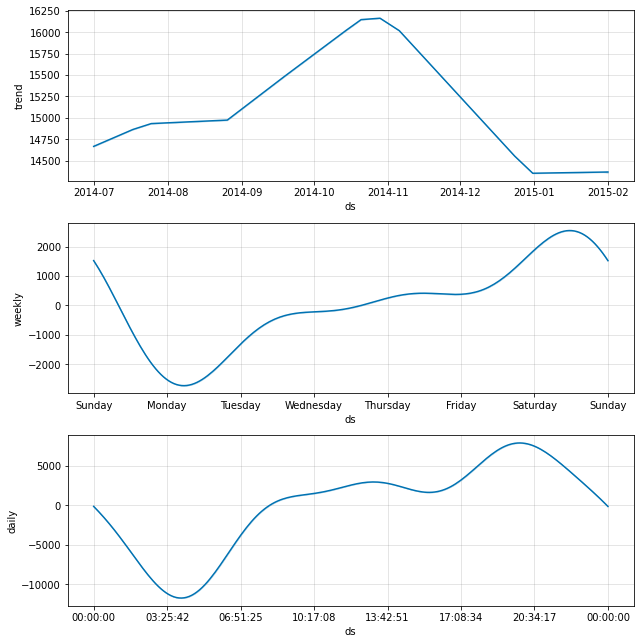

In [69]:
# plot components
comp = m.plot_components(forecast)

As we had detected, the outliers (anomalies) have been detected in the time-series data along with the forecast